# Mother machine simulations

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/')

from SyMBac.simulation import Simulation
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import Renderer
from SyMBac.PSF import Camera
from SyMBac.misc import get_sample_images
real_image = get_sample_images()["E. coli 100x"]

/home/georgeos/Documents/GitHub/SyMBac/SyMBac/cell_simulation.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


## Running a simulation

Mother machine simulations are handled with the  `Simulation` class.

Instantiating a `Simulation` object requires the following arguments to be specified:

- *trench_length*: The length of the trench.
- *trench_width*: The width of the trench.
- *cell_max_length*: The maximum allowable length of a cell in the simulation.
- *cell_width*: The average width of cells in the simulation.
- *sim_length*: The number of timesteps to run the simulation for.
- *pix_mic_conv*: The number of microns per pixel in the simulation. 
- *gravity*: The strength of the arbitrary gravity force in the simulations.
- *phys_iters*: The number of iterations of the rigid body physics solver to run each timestep. Note that this affects how gravity works in the simulation, as gravity is applied every physics iteration, higher values of *phys_iters* will result in more gravity if it is turned on.
- *max_length_var*: The variance applied to the normal distribution which has mean *cell_max_length*, from which maximum cell lengths are sampled.
- *width_var*: The variance applied to the normal distribution of cell widths which has mean *cell_width*.
- *save_dir*: The save location of the return value of the function. The output will be pickled and saved here, so that the simulation can be reloaded later withuot having to rerun it, for reproducibility. If you don't want to save it, just leave it as /tmp/`.

In [4]:
my_simulation = Simulation(
    trench_length=15,
    trench_width=1.3,
    cell_max_length=6.65, #6, long cells # 1.65 short cells
    cell_width= 1, #1 long cells # 0.95 short cells
    sim_length = 100,
    pix_mic_conv = 0.065,
    gravity=0,
    phys_iters=15,
    max_length_var = 0.,
    width_var = 0.,
    lysis_p = 0.,
    save_dir="/tmp/",
    resize_amount = 3
)

In [5]:
my_simulation.run_simulation(show_window=False)

  0%|          | 0/100 [00:00<?, ?it/s]

This method takes two arguments. 

- *do_transformation* - Whether or not to bend or morph the cells to increase realism.
- *label_masks* - This controls whether the output training masks will be binary or labeled. Binary masks are used to train U-net (e.g DeLTA), wheras labeled masks are used to train Omnipose

In [6]:
my_simulation.draw_simulation_OPL(do_transformation=True, label_masks=True)

Timeseries Properties:   0%|          | 0/98 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/98 [00:00<?, ?it/s]

## Simulation visualisation

We can visualise one of the OPL images and masks from the simulation:

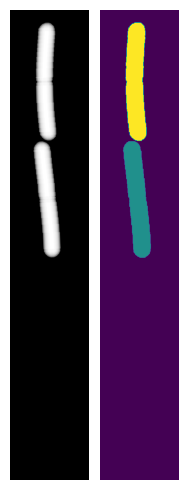

In [7]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2,5))
ax1.imshow(my_simulation.OPL_scenes[-1], cmap="Greys_r")
ax1.axis("off")
ax2.imshow(my_simulation.masks[-1])
ax2.axis("off")
plt.tight_layout()

In [8]:
my_simulation.visualise_in_napari()

## Point spread function (PSF) generation

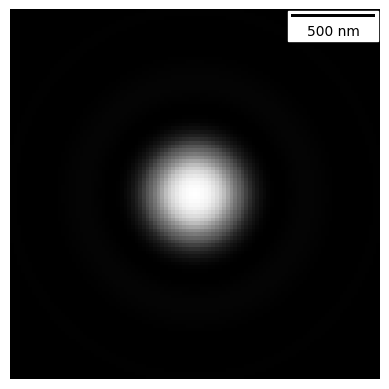

In [9]:
# A 2D simple fluorescence kernel based on Airy
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.2, 
    n = 1.3, 
    resize_amount = 3, 
    pix_mic_conv = 0.065, 
    apo_sigma = None, 
    mode="simple fluo")
my_kernel.calculate_PSF()
my_kernel.plot_PSF()

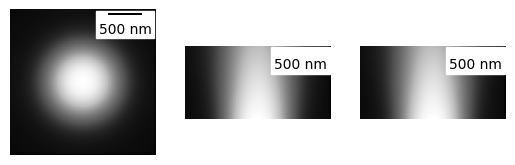

In [10]:
# A 3D fluorescence kernel based on the psfmodels library
# (note the larger looking PSF due to the summed projection)
# (During convolution, each slice of the image is convolved with the relevent 
# volume slice of the cell)
my_kernel = PSF_generator(
    z_height=50,
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.2, 
    n = 1.3, 
    resize_amount = 3, 
    pix_mic_conv = 0.065, 
    apo_sigma = None, 
    mode="3D fluo")
my_kernel.calculate_PSF()
my_kernel.plot_PSF()

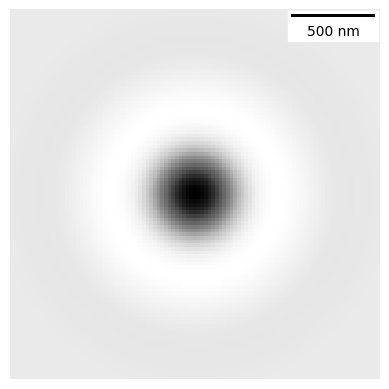

In [11]:
# A phase contrast kernel
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.2, 
    n = 1.3, 
    resize_amount = 3, 
    pix_mic_conv = 0.065, 
    apo_sigma = 20, 
    mode="phase contrast", 
    condenser = "Ph3")
my_kernel.calculate_PSF()
my_kernel.plot_PSF()

## Camera model

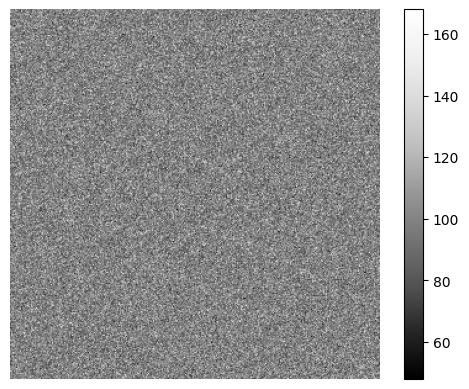

In [12]:
my_camera = Camera(baseline=100, sensitivity=2.9, dark_noise=8)
my_camera.render_dark_image(size=(300,300));

In [13]:
my_renderer = Renderer(simulation = my_simulation, PSF = my_kernel, real_image = real_image, camera = my_camera)

Next we shall extract some pixels from the real image which we will use to optimise the synthetic image. We will extract the pixel intensities and variances from the 3 important regions of the image. The cells, the device, and the media. These are the same three aforementioned intensities for which we “guessed” some parameters in the previous code block.

We use napari to load the real image, and create three layers above it, called `media_label`, `cell_label`, and `device_label`. We will then select each layer and draw over the relevant regions of the image.

A video below shows how it's done:

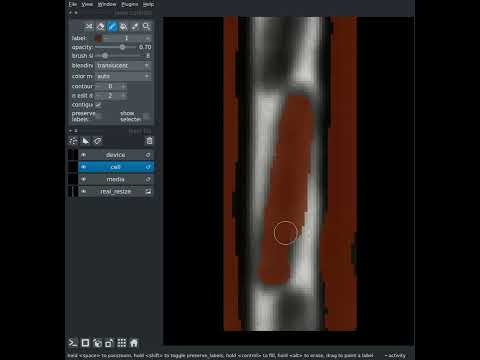

In [14]:
from IPython.display import YouTubeVideo
YouTubeVideo("sPC3nV_5DfM")

In [15]:
my_renderer.select_intensity_napari()

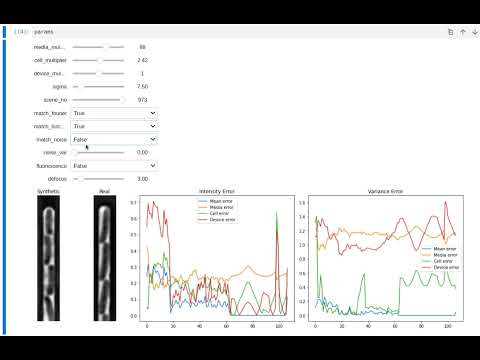

In [16]:
YouTubeVideo("PeeyotMQAQU")

In [18]:
my_renderer.optimise_synth_image(manual_update=False)

interactive(children=(IntSlider(value=75, description='media_multiplier', max=300, min=-300), FloatSlider(valu…

In [ ]:
my_renderer.generate_training_data(sample_amount=0.1, randomise_hist_match=True, randomise_noise_match=True, burn_in=40, n_samples = 500, save_dir="/tmp/test/", in_series=False)

Sample generation:  30%|██████▌               | 150/500 [00:15<00:34, 10.07it/s]